In [11]:
model_input_file = "../lvt-schiphol-assignment-snakemake/data/model_input/delays_base_input.csv"
train_test_file = "../lvt-schiphol-assignment-snakemake/data/model_input/train_test__0.2__sample.csv"

In [12]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin

import sys
sys.path.append("../")

from src.data.google_storage_io import read_csv_data, write_csv_data
from src.evaluation.regression import get_regression_metrics


In [13]:
df = read_csv_data(model_input_file)
train_test = read_csv_data(train_test_file)

Reading file from local directory
File:	../lvt-schiphol-assignment-snakemake/data/model_input/delays_base_input.csv

Reading file from local directory
File:	../lvt-schiphol-assignment-snakemake/data/model_input/train_test__0.2__sample.csv



In [88]:
train_test["id"].drop_duplicates().shape

(477778,)

In [89]:
df["id"].drop_duplicates().shape

(477778,)

In [87]:
len(train_test), len(df), len(pd.merge(df, train_test, on="id", how="left"))

(487716, 487716, 507650)

In [84]:
%%time

def split_train_test(df, train_test, target="scheduleDelaySeconds"):
    # merge by `id` and group by train/test set labels
    df_set_groups = pd.merge(df, train_test, on="id", how="left").groupby("model_set")
    
    # get data per train/test set
    df_train, df_test = df_set_groups.get_group("train"), df_set_groups.get_group("test")
    print(len(df_train), len(df_test))
    # split target from features
    X_train, y_train = df_train.drop(columns=[target]), df_train[target]
    X_test, y_test = df_test.drop(columns=[target]),  df_test[target]
    
    print(len(X_train), len(X_test), len(df))
    assert (len(X_train) + len(X_test)) == len(df)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_train_test(df, train_test)

406033 101617
406033 101617 487716


AssertionError: 

# Train model

In [15]:
class AverageBaseline(BaseEstimator):
    def __init__(self):
        self._average_y = None
   
    @property
    def average_y(self):
        return self._average_y
    
    def fit(self, X, y):
        """calculate the average values of `y` and save  internally"""
        self._average_y = np.mean(y)
        return self
    
    def predict(self, X):
        """return trained average y value for all observations in X"""
        return np.array([self.average_y] * X.shape[0])

In [16]:
# train
avg_baseline = AverageBaseline().fit(X_train, y_train)

# Evaluate model

In [17]:
# predict
preds_train = avg_baseline.predict(X_train) 
preds_test = avg_baseline.predict(X_test)
preds_test

array([940.57551237, 940.57551237, 940.57551237, ..., 940.57551237,
       940.57551237, 940.57551237])

In [18]:
X_test.shape

(94350, 7)

In [19]:
X_train.shape

(393366, 7)

In [20]:
# calculate regression metrics
train_metrics = get_regression_metrics(y_train, preds_train) 
test_metrics = get_regression_metrics(y_test, preds_test)

metrics_dict = dict(
    train = train_metrics,
    test_ = test_metrics)
metrics_dict

{'train': {'mae': 987.1919936308009,
  'mse': 7565240.986105768,
  'rmse': 2750.4983159612675,
  'mape': inf,
  'median_absolute_error': 702.5755123727013,
  'max_error': 280180.4244876273,
  'explained_variance': 0.0,
  'r2_score': 0.0,
  'wce': 193837215.1364897},
 'test_': {'mae': 896.8729317853183,
  'mse': 3757542.1140603386,
  'rmse': 1938.438060413677,
  'mape': inf,
  'median_absolute_error': 701.5755123727013,
  'max_error': 163102.4244876273,
  'explained_variance': 0.0,
  'r2_score': -0.003657227644512373,
  'wce': 42543659.52644593}}

In [22]:
X_train

,id,aircraftRegistration,airlineCode,terminal,serviceType,scheduleDateTime,actualOffBlockTime
0,123414481790510775,PHPXB,148.0,NaN,NaN,2018-01-01 03:30:00+01:00,2018-01-01 03:22:00+01:00
1,123414479288269149,PHHSJ,164.0,1.0,J,2018-01-01 06:00:00+01:00,2018-01-01 05:58:22+01:00
2,123414479666542945,PHHSG,100.0,1.0,J,2018-01-01 06:05:00+01:00,2018-01-01 06:00:00+01:00
3,123414479288365061,PHHSG,164.0,1.0,J,2018-01-01 06:05:00+01:00,2018-01-01 06:00:00+01:00
5,123414479666545913,PHHZN,100.0,1.0,J,2018-01-01 06:20:00+01:00,2018-01-01 06:30:11+01:00
...,...,...,...,...,...,...,...
487711,124763272032451639,PHBHE,1551.0,2.0,J,2018-07-12 17:25:00+02:00,2018-07-12 17:26:20+02:00
487712,124763270368084713,PHBHL,80.0,2.0,J,2018-07-12 17:25:00+02:00,2018-07-12 17:25:12+02:00
487713,124763270625998761,B2098,488.0,NaN,F,2018-07-12 17:45:00+02:00,2018-07-12 17:12:45+02:00
487714,124763271129903067,OOFPE,4804.0,NaN,NaN,2018-07-12 17:50:00+02:00,2018-07-12 15:25:10+02:00


0         2018-01-01
1         2018-01-01
2         2018-01-01
3         2018-01-01
5         2018-01-01
             ...    
487711    2018-07-12
487712    2018-07-12
487713    2018-07-12
487714    2018-07-12
487715    2018-07-11
Name: scheduleDateTime, Length: 393366, dtype: object

In [56]:
def datetime_to_date(dt):
    return pd.to_datetime(dt, utc=True).dt.date

def datetime_to_date_hour(dt):
    return pd.to_datetime(dt, utc=True).dt.floor('H')

In [57]:
for quant in np.linspace(0, 1, 11):
    print(quant, np.quantile(y_train, quant))

0.0 -40198.0
0.1 -74.0
0.2 59.00000000000001
0.30000000000000004 172.0
0.4 293.0
0.5 426.0
0.6000000000000001 609.0
0.7000000000000001 858.0
0.8 1255.0
0.9 2189.0
1.0 281121.0


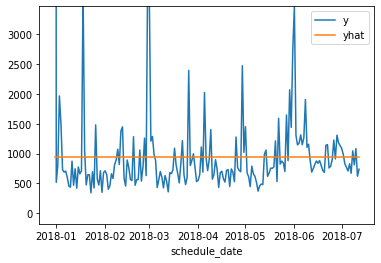

In [59]:
X_train[["id", "scheduleDateTime"]] \
    .assign(
        y = y_train,
        yhat = preds_train,
        error = preds_train - y_train,
        schedule_date = datetime_to_date(X_train["scheduleDateTime"])) \
    .groupby("schedule_date").mean().reset_index() \
    [["schedule_date", "y", "yhat"]] \
    .plot(x="schedule_date", 
          ylim=(np.quantile(y_train, 0.05), np.quantile(y_train, 0.95)))

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt

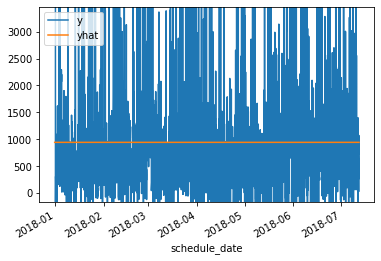

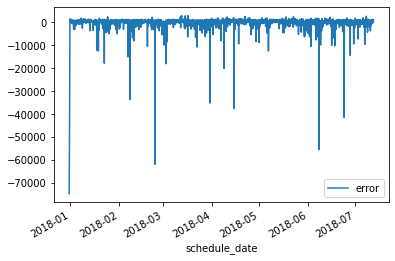

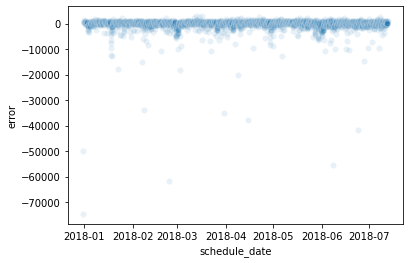

In [77]:
tmp_plot_data = X_train[["id", "scheduleDateTime"]] \
    .assign(
        y = y_train,
        yhat = preds_train,
        error = preds_train - y_train,
        schedule_date = datetime_to_date_hour(X_train["scheduleDateTime"])) \
    .groupby("schedule_date").mean().reset_index() 

tmp_plot_data[["schedule_date", "y", "yhat"]].plot(x="schedule_date", ylim=(np.quantile(y_train, 0.05), np.quantile(y_train, 0.95)))
tmp_plot_data[["schedule_date", "error"]].plot(x="schedule_date")
plt.show()

sns.scatterplot(data=tmp_plot_data, x="schedule_date", y="error", alpha=0.1)
plt.show()